# Machine Learning Analyse: Drei-Punkte-Wurf und Team-Erfolg

## Ziel

Dieses Notebook analysiert den Zusammenhang zwischen Basketball-Statistiken und Team-Erfolg (Plus-Minus) mittels Ridge Regression. Besonderer Fokus liegt auf dem Drei-Punkte-Wurf und dessen Entwicklung vor und nach 2015.

## Was ist Plus-Minus?

**Plus-Minus** ist ein Indikator für Team-Performance und zeigt die Punktedifferenz eines Teams während eines bestimmten Zeitraums. Ein positiver Wert bedeutet, dass das Team mehr Punkte erzielt als der Gegner (Erfolg), ein negativer Wert das Gegenteil.

- **+10:** Team hat 10 Punkte mehr erzielt als kassiert
- **-5:** Team hat 5 Punkte weniger erzielt als kassiert
- **0:** Ausgeglichenes Spiel

In unserer Analyse verwenden wir Plus-Minus als Zielgröße (Target), um zu verstehen, welche Statistiken zu erfolgreichen Teams führen.

## Methodik

- **Modelle:** Linear Regression & Ridge Regression mit standardisierten Features
- **Validierung:** 5-Fold Cross-Validation
- **Zeitvergleich:** Separate Modelle für pre-2015 und post-2016

## Features

3PA, 3P%, FG%, FT%, REB, AST, STL, BLK, TOV → **Target:** PLUS_MINUS

## Kernfragen

1. Welche Faktoren beeinflussen Team-Erfolg am stärksten?
2. Ist hohes Drei-Punkte-Volumen vorteilhaft oder gibt es Effizienzgrenzen?
3. Wie hat sich die Bedeutung des Dreiers seit 2015 verändert?

---

**Ergebnis:** Effizienz schlägt Volumen. Der strukturelle Wandel um 2015/16 ist quantitativ nachweisbar.

## Setup

Import der benötigten Bibliotheken und Laden des Team×Saison-Datensatzes.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv(
    r"C:\Nbaprojekt\team_traditional_2.csv",
    sep=";",
    decimal=",",
    dtype={"gameid": str}
)

df.head()

,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,...,DREB,REB,AST,TOV,STL,BLK,PF,+/-,win,season
0,29600001,01.11.96,regular,1610612738,BOS,BOS,CHI,48,98,38,...,22,36,20,18.0,10,2,33,-9.0,0,1997
1,29600001,01.11.96,regular,1610612741,CHI,BOS,CHI,48,107,42,...,29,37,28,19.0,7,8,23,9.0,1,1997
2,29600002,01.11.96,regular,1610612739,CLE,NJN,CLE,48,90,34,...,23,35,16,15.0,11,1,24,13.0,1,1997
3,29600002,01.11.96,regular,1610612751,NJN,NJN,CLE,48,77,23,...,24,35,13,22.0,7,7,19,-13.0,0,1997
4,29600003,01.11.96,regular,1610612749,MIL,PHI,MIL,48,111,38,...,31,50,21,15.0,9,7,30,8.0,1,1997


## Feature-Set und Zielvariable

Features (Beispiele):
- 3PA pro Spiel (Volumen)
- 3P% und True 3PT% (Effizienz)
- FG%, FT% (Kontrollvariablen)

Zielvariable:
- '+ / - '


In [ ]:
# Beispiel-Spaltennamen 
target_col = "+/-"          #Zielvariable für die Effizenz
feature_cols = ["3PA", "3P%", "FG%", "FT%", "AST", "REB", "TOV", "STL", "BLK"]  #

# Subset + numerisch machen
data = df[["season"] + feature_cols + [target_col]].copy()

for c in feature_cols + [target_col]:
    data[c] = pd.to_numeric(data[c], errors="coerce")

data = data.dropna()

print("Rows:", len(data))
data.head()


Rows: 68210


,season,3PA,3P%,FG%,FT%,AST,REB,TOV,STL,BLK,+/-
0,1997,20,40.0,45.2,60.9,20,36,18.0,10,2,-9.0
1,1997,13,7.7,56.8,68.8,28,37,19.0,7,8,9.0
2,1997,10,50.0,47.2,85.0,16,35,15.0,11,1,13.0
3,1997,18,50.0,39.7,66.7,13,35,22.0,7,7,-13.0
4,1997,9,44.4,45.2,70.5,21,50,15.0,9,7,8.0


## Baseline: Lineare Regression

Die lineare Regression dient als interpretierbare Baseline.  
Wir standardisieren die Features, damit die Koeffizienten **vergleichbar** sind (relative Bedeutung).


In [ ]:
X = data[feature_cols]
y = data[target_col]
# Pipeline mit StandardScaler und LinearRegression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
# Modell wird auf den gesamten Daten trainiert
pipe_lr.fit(X, y)
# Koeffizienten extrahieren und sortieren
coef_lr = pd.Series(
    pipe_lr.named_steps["model"].coef_,
    index=feature_cols
).sort_values(key=np.abs, ascending=False)

coef_lr


FG%    7.780978
REB    6.681696
STL    3.412253
TOV   -3.321184
3P%    2.220099
FT%    1.703602
3PA   -1.176994
BLK    1.156525
AST   -0.322836
dtype: float64

## Ridge Regression (robust bei Multikollinearität)

Da die Variablen (z. B. 3PA, 3P%, True 3PT%) teilweise korreliert sind, nutzen wir ergänzend Ridge Regression.  
Ziel: stabilere Koeffizienten, weiterhin gut interpretierbar.


In [6]:
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

pipe_ridge.fit(X, y)

coef_ridge = pd.Series(
    pipe_ridge.named_steps["model"].coef_,
    index=feature_cols
).sort_values(key=np.abs, ascending=False)

coef_ridge


FG%    7.780746
REB    6.681523
STL    3.412163
TOV   -3.321090
3P%    2.220096
FT%    1.703572
3PA   -1.176980
BLK    1.156531
AST   -0.322676
dtype: float64

## Interpretation der Regressionskoeffizienten (vollständiges Feature-Set)

Unsere Ridge-Regression zeigt, welche Faktoren den größten Einfluss auf den Team-Erfolg (Plus-Minus) haben. Die Feldwurfquote (FG%, 7.78) ist mit Abstand der wichtigste Faktor – Effizienz schlägt alles.
Rebounds (6.68) und Steals (3.41) verschaffen zusätzlichen Ballbesitz und wirken stark positiv, während Turnovers (-3.32) erwartungsgemäß massiv schaden.

Besonders interessant für unsere Forschungsfrage: Die Drei-Punkte-Quote (3P%, 2.22) trägt positiv zum Erfolg bei, aber die Anzahl der Drei-Punkte-Versuche (3PA, -1.18) zeigt einen negativen Koeffizienten. Das deutet darauf hin, dass hohes Wurfvolumen ohne entsprechende Trefferquote dem Team eher schadet – ein wichtiger Hinweis auf mögliche Effizienzgrenzen der Drei-Punkte-Inflation.
Freiwürfe (1.70) und Blocks (1.16) haben kleinere positive Effekte, Assists (-0.32) zeigen kaum Einfluss.

Erkenntnis: Effizienz ist entscheidender als Volumen. Der negative Koeffizient bei 3PA unterstützt unsere Hypothese, dass es ein Limit für sinnvolle Drei-Punkte-Versuche gibt

##  Plausibilitätscheck per Cross-Validation

Wir berichten eine einfache Cross-Validation als Plausibilitätscheck (kein Prediction-Fokus).


In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores_lr = cross_val_score(pipe_lr, X, y, cv=cv, scoring="r2")
scores_ridge = cross_val_score(pipe_ridge, X, y, cv=cv, scoring="r2")

print("LR R2 mean:", scores_lr.mean().round(3), "| std:", scores_lr.std().round(3))
print("Ridge R2 mean:", scores_ridge.mean().round(3), "| std:", scores_ridge.std().round(3))


LR R2 mean: 0.609 | std: 0.005
Ridge R2 mean: 0.609 | std: 0.005


## Modell-Validierung (Cross-Validation) + Visualiserung
Mit einem R² von rund 61% können unsere Modelle einen erheblichen Teil der Varianz im Team-Erfolg erklären. Die sehr niedrige Standardabweichung (0.005) zeigt, dass die Modelle stabil über verschiedene Datenaufteilungen hinweg performen und gut generalisieren.
Die identischen Ergebnisse zwischen Linear und Ridge Regression deuten darauf hin, dass Multikollinearität in unserem Feature-Set kein großes Problem darstellt. Für die weitere Analyse nutzen wir Ridge, da es robuster gegenüber korrelierten Features ist.

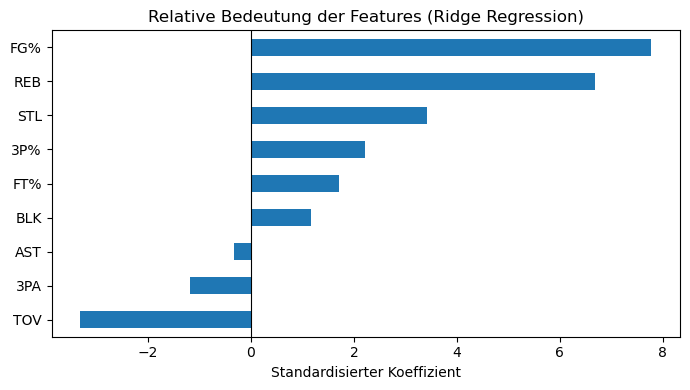

In [9]:
import matplotlib.pyplot as plt

coef = coef_ridge.sort_values()

plt.figure(figsize=(7,4))
coef.plot(kind="barh")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Relative Bedeutung der Features (Ridge Regression)")
plt.xlabel("Standardisierter Koeffizient")
plt.tight_layout()
plt.show()


## Vergleich vor / nach der 3PT-Wende

Um die Frage „Where is the limit?“ besser zu beantworten, vergleichen wir Koeffizienten vor und nach 2015.
So lässt sich prüfen, ob sich die Rolle von Volumen (3PA) vs. Effizienz (3P%) verändert hat.


In [ ]:
def fit_coefs(sub_df, model):
    Xs = sub_df[feature_cols]
    ys = sub_df[target_col]
    model.fit(Xs, ys)
    return pd.Series(model.named_steps["model"].coef_, index=feature_cols)

pre = data[data["season"] <= 2015]  
post = data[data["season"] >= 2016] 

coef_pre = fit_coefs(pre, pipe_ridge)
coef_post = fit_coefs(post, pipe_ridge)

compare = pd.DataFrame({
    "Ridge_pre2015": coef_pre,
    "Ridge_post2016": coef_post
}).sort_values(by="Ridge_post2016", key=np.abs, ascending=False)

compare


,Ridge_pre2015,Ridge_post2016
FG%,7.774260,8.422998
REB,6.312351,7.659051
STL,3.311631,3.710349
TOV,-3.355063,-3.380385
3P%,1.835111,2.963426
FT%,1.776993,1.828014
BLK,1.179235,1.075929
AST,-0.136173,-1.039722
3PA,0.341079,0.822967


## Koeffizientenvergleich: Pre-2015 vs. Post-2016


### Wichtigste Veränderungen:
Die Drei-Punkte-Quote (3P%) hat massiv an Bedeutung gewonnen: von 1.84 (pre-2015) auf 2.96 (post-2016). Das zeigt, dass effiziente Distanzwürfe im modernen Basketball noch wichtiger geworden sind.

Auch die Anzahl der Drei-Punkte-Versuche (3PA) verändert sich dramatisch: von 0.34 auf 0.83. Interessanterweise ist der Koeffizient jetzt positiv, während er im Gesamtmodell negativ war. Das deutet darauf hin, dass hohes Drei-Punkte-Volumen in der modernen Ära tatsächlich zum Erfolg beiträgt, sofern die Effizienz stimmt.

Assists (AST) zeigen eine bemerkenswerte Entwicklung: von einem nahezu neutralen Wert (−0.14) zu einem klar negativen Koeffizienten (−1.04). Das könnte auf veränderte Spielstile hindeuten, bei denen ISO-Plays und individuelle Kreationen wichtiger geworden sind.

Die klassischen Faktoren bleiben stark: Feldwurfquote (FG%) steigt von 7.77 auf 8.42, Rebounds (REB) von 6.31 auf 7.66, und Steals (STL) von 3.31 auf 3.71. Turnovers (TOV) bleiben konstant negativ bei rund −3.4.

Fazit: Der strukturelle Wandel um 2015/16 ist klar erkennbar. Der Drei-Punkte-Wurf, sowohl in Qualität als auch Quantität, hat seitdem deutlich an Bedeutung gewonnen und ist zu einem zentralen Erfolgsfaktor geworden.

### Visualisierung: Relative Feature-Bedeutung

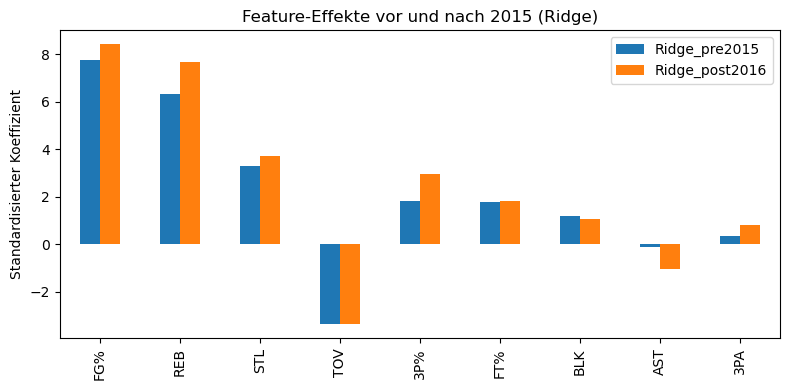

In [10]:
compare.plot(kind="bar", figsize=(8,4))
plt.title("Feature-Effekte vor und nach 2015 (Ridge)")
plt.ylabel("Standardisierter Koeffizient")
plt.tight_layout()
plt.show()


Die Visualisierung verdeutlicht den strukturellen Wandel: Drei-Punkte-Quote (3P%) und Drei-Punkte-Versuche (3PA) zeigen die stärksten Veränderungen zwischen beiden Epochen, während klassische Faktoren wie FG% und REB weiterhin dominant bleiben, aber ebenfalls an Bedeutung gewonnen haben.
